In [2]:
import os
import sys
sys.path.append("../cnn")
sys.path.append("../utils")

import torch
from torch.autograd import Variable

from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# import seaborn as sns; sns.set()

from cnn_md import CNNMultidecoder
from cnn_md import CNNDomainAdversarialMultidecoder
from cnn_md import CNNGANMultidecoder
from kaldi_data import read_next_utt

In [6]:
# Set up environment variables for the model we want to examine
# NOT necessarily the current environment variables!!

feat_dim=40
left_splice=5
right_splice=5

optimizer="Adam"
learning_rate="0.001" # Use string instead of float to prevent Python's auto-formatting...
l2_reg="0.0" # Use string instead of float to prevent Python's auto-formatting...
epochs=100
batch_size=64

enc_channels=[64,64]
enc_kernels=[5,5]
enc_downsamples=[3,3]
enc_fc=[]

latent_dim=256

dec_fc=[]
dec_channels=[64,64]
dec_kernels=[5,5]
dec_upsamples=[3,3]

use_batch_norm=False
use_batch_norm_str = "true" if use_batch_norm else "false"
activation="ReLU"
weight_init="xavier_uniform"

enc_channels_delim="_" + "_".join(map(str, enc_channels))
if len(enc_channels) == 0:
     # need to recreate bash join behavior with empty array
    enc_channels_delim="_"
enc_kernels_delim="_" + "_".join(map(str, enc_kernels))
if len(enc_kernels) == 0:
     # need to recreate bash join behavior with empty array
    enc_kernels_delim="_"
enc_downsamples_delim="_" + "_".join(map(str, enc_downsamples))
if len(enc_downsamples) == 0:
     # need to recreate bash join behavior with empty array
    enc_downsamples_delim="_"
enc_fc_delim="_" + "_".join(map(str, enc_fc))
if len(enc_fc) == 0:
     # need to recreate bash join behavior with empty array
    enc_fc_delim="_"
    
dec_fc_delim="_" + "_".join(map(str, dec_fc))
if len(dec_fc) == 0:
     # need to recreate bash join behavior with empty array
    dec_fc_delim="_"
dec_channels_delim="_" + "_".join(map(str, dec_channels))
if len(dec_channels) == 0:
     # need to recreate bash join behavior with empty array
    dec_channels_delim="_"
dec_kernels_delim="_" + "_".join(map(str, dec_kernels))
if len(dec_kernels) == 0:
     # need to recreate bash join behavior with empty array
    dec_kernels_delim="_"
dec_upsamples_delim="_" + "_".join(map(str, dec_upsamples))
if len(dec_upsamples) == 0:
     # need to recreate bash join behavior with empty array
    dec_upsamples_delim="_"

use_transformation = True
use_transformation_str = "true" if use_transformation else "false"
use_reconstruction = True
use_reconstruction_str = "true" if use_reconstruction else "false"
    
expt_name = "RECON_%s_TRANS_%s_ENC_C%s_K%s_P%s_F%s/LATENT_%d/DEC_F%s_C%s_K%s_P%s/ACT_%s_BN_%s_WEIGHT_INIT_%s/OPT_%s_LR_%s_L2_REG_%s_EPOCHS_%d_BATCH_%d" % (use_reconstruction_str,
                                                                                                                                        use_transformation_str,
                                                                                                                                        enc_channels_delim,
                                                                                                                                        enc_kernels_delim, 
                                                                                                                                        enc_downsamples_delim, 
                                                                                                                                        enc_fc_delim,
                                                                                                                                        latent_dim,
                                                                                                                                        dec_fc_delim,
                                                                                                                                        dec_channels_delim,
                                                                                                                                        dec_kernels_delim,                                                                                                                   
                                                                                                                                        dec_upsamples_delim,
                                                                                                                                        activation,
                                                                                                                                        use_batch_norm_str,
                                                                                                                                        weight_init,
                                                                                                                                        optimizer,
                                                                                                                                        learning_rate,
                                                                                                                                        l2_reg,
                                                                                                                                        epochs,
                                                                                                                                        batch_size)

time_dim = (left_splice + right_splice + 1)
freq_dim = feat_dim

print("Using experiment %s" % expt_name)

clean_dataset="timit_clean"
# dirty_dataset="timit_dirty_single_rir"
dirty_dataset="timit_gaussian_5.0"

domain_adv_fc = [512]
domain_adv_fc_delim="_" + "_".join(map(str, domain_adv_fc))
if len(domain_adv_fc) == 0:
     # need to recreate bash join behavior with empty array
    domain_adv_fc_delim="_"
domain_adv_activation = "Sigmoid"

gan_fc = [512]
gan_fc_delim="_" + "_".join(map(str, gan_fc))
if len(gan_fc) == 0:
     # need to recreate bash join behavior with empty array
    gan_fc_delim="_"
gan_activation = "Sigmoid"

Using experiment RECON_true_TRANS_true_ENC_C_64_64_K_5_5_P_3_3_F_/LATENT_256/DEC_F__C_64_64_K_5_5_P_3_3/ACT_ReLU_BN_false_WEIGHT_INIT_xavier_uniform/OPT_Adam_LR_0.001_L2_REG_0.0_EPOCHS_100_BATCH_64


In [7]:
# Load checkpoint (potentially trained on GPU) into CPU memory (hence the map_location)
domain_adversarial = False
gan = False
checkpoint_dir = "/data/sls/scratch/atitus5/meng/models/cnn/%s/%s" % (dirty_dataset,
                                                                      expt_name)
if domain_adversarial:
    checkpoint_file = "%s/best_md_domain.pth.tar" % checkpoint_dir
elif gan:
    checkpoint_file = "%s/best_md_gan.pth.tar" % checkpoint_dir
else:
    checkpoint_file = "%s/best_md_vanilla.pth.tar" % checkpoint_dir
        
checkpoint = torch.load(checkpoint_file, map_location=lambda storage,loc: storage)
print("Loaded checkpoint")

Loaded checkpoint


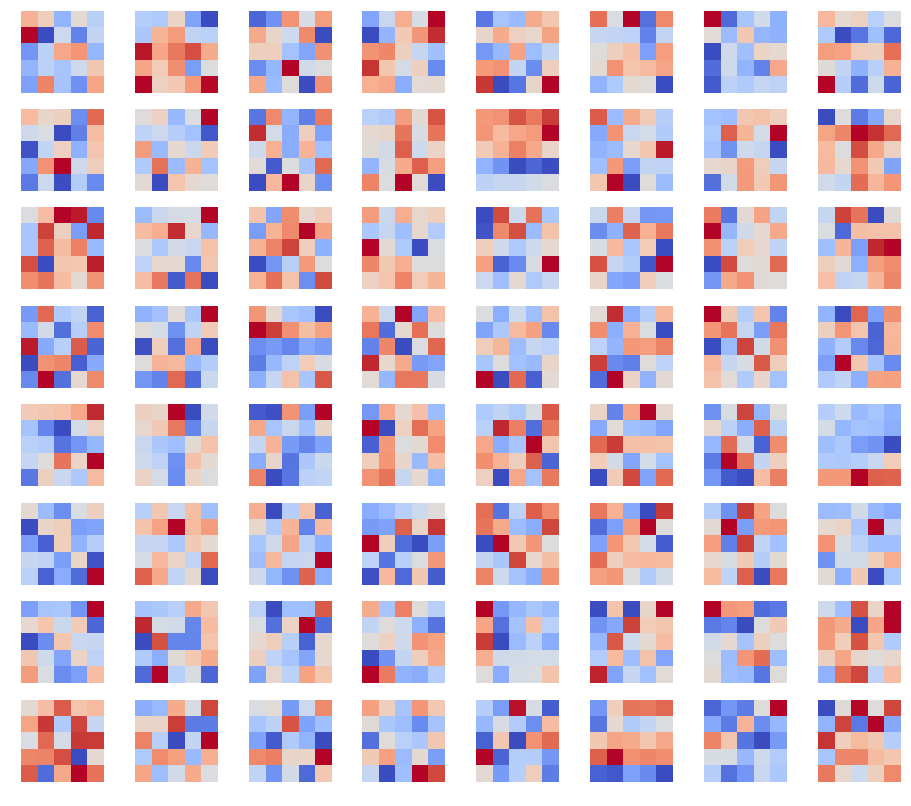

In [8]:
color_map = "coolwarm"
# color_map = "viridis"
def plotFirstLayerKernels(name, num_cols):
    weights = checkpoint["state_dict"][name].numpy()
    if len(weights.shape) != 4:
        print("plotFirstLayerKernels expects a 4D tensor; got a %dD tensor instead" % len(weights.shape))
    if weights.shape[1] != 1:
        print("plotFirstLayerKernels can only visualize 1 input channel of data")
    num_kernels = weights.shape[0]
        
    num_rows = int(num_kernels // num_cols) + 1
    kernels = weights.reshape((num_kernels, weights.shape[2], weights.shape[3]))
    
    fig = plt.figure(figsize=(16, 16)) 
    for row in range(num_rows):
        for col in range(num_cols):
            kernel_idx = (row * num_cols) + col
            if kernel_idx < num_kernels:
                ax = plt.subplot(num_rows, num_cols, kernel_idx + 1)
                ax.axis('off')   # Pretty-up the result a bit
                plt.imshow(kernels[kernel_idx], cmap=color_map, aspect='equal')
    plt.show()
    
col_count = 8
plotFirstLayerKernels("encoder_conv.conv2d_0.weight", col_count)